The generated DAG used for our experiments.

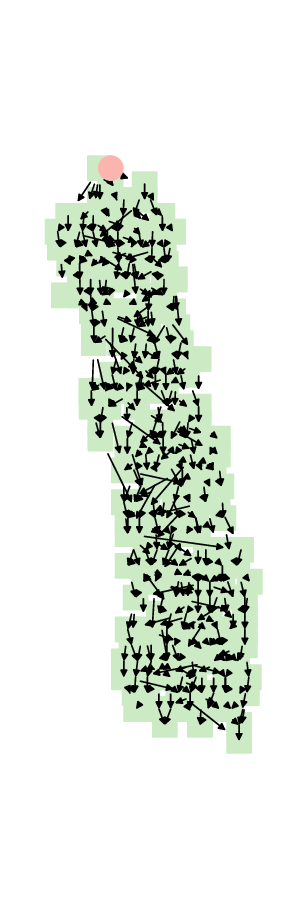

In [316]:
from wand.image import Image as WImage
WImage(filename='./dag.pdf', resolution=100)

The same DAG recolourized to devices to the selected devices (according to the scheduling policy) is shown in the following cell.

filename is zenith-random-recoloured_dag.pdf
filename is zenith-ftf-recoloured_dag.pdf
filename is zenith-roundrobin-recoloured_dag.pdf
filename is zenith-depend-recoloured_dag.pdf
filename is zenith-sdq-recoloured_dag.pdf
filename is zenith-profile-recoloured_dag.pdf


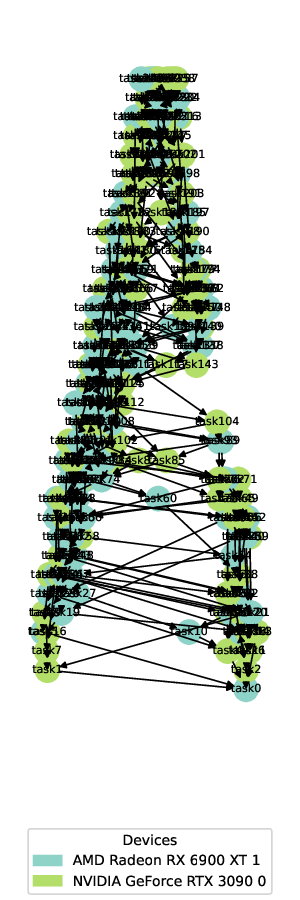

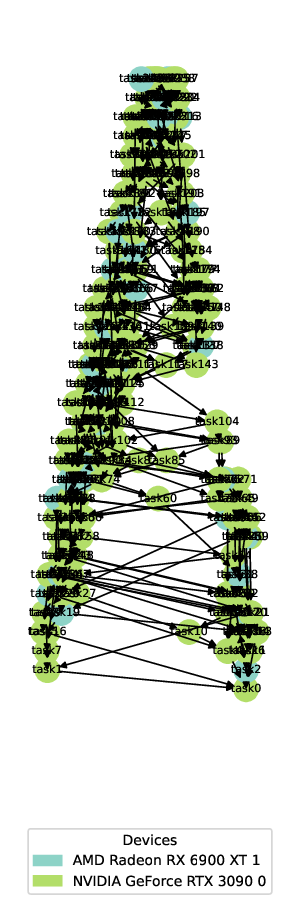

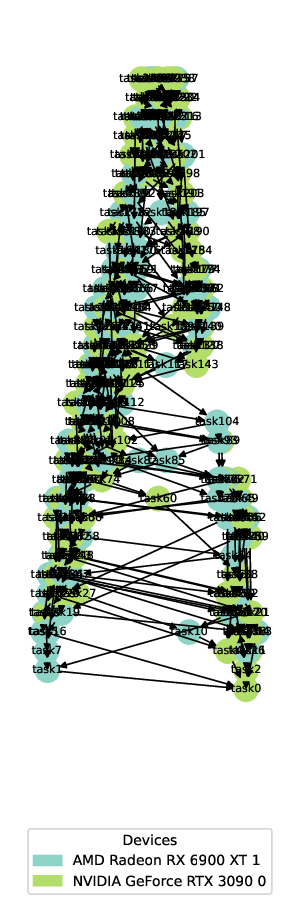

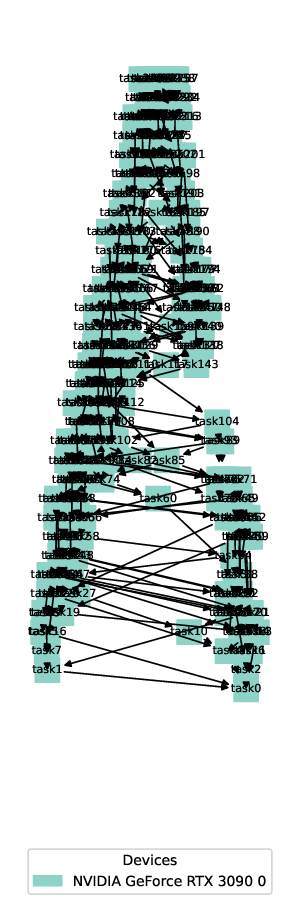

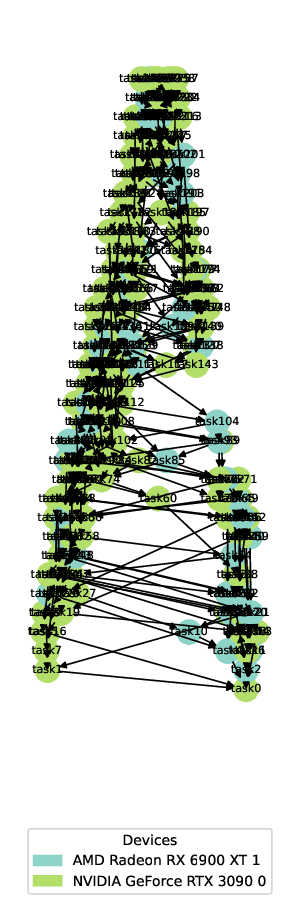

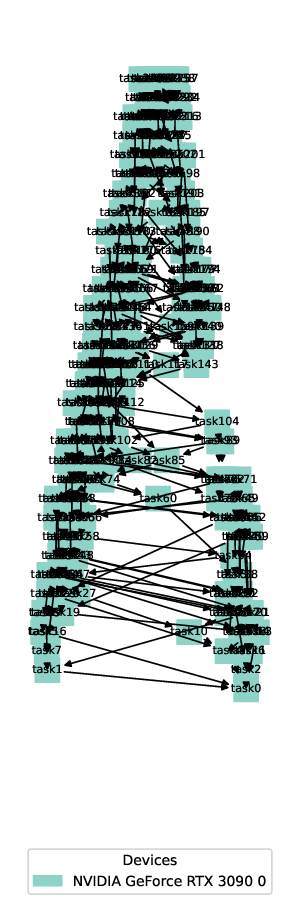

In [70]:
from wand.image import Image as WImage
import glob
dag_images = glob.glob("zenith-*-recoloured_dag.pdf")
images = []
for i in dag_images:
    print("filename is {}".format(i))
    images.append(WImage(filename=i, resolution=100))
display(*images)

Along with the actual timeline:

filename is zenith-sdq-timeline.pdf
filename is zenith-roundrobin-timeline.pdf
filename is zenith-depend-timeline.pdf
filename is zenith-profile-timeline.pdf
filename is zenith-ftf-timeline.pdf
filename is zenith-random-timeline.pdf


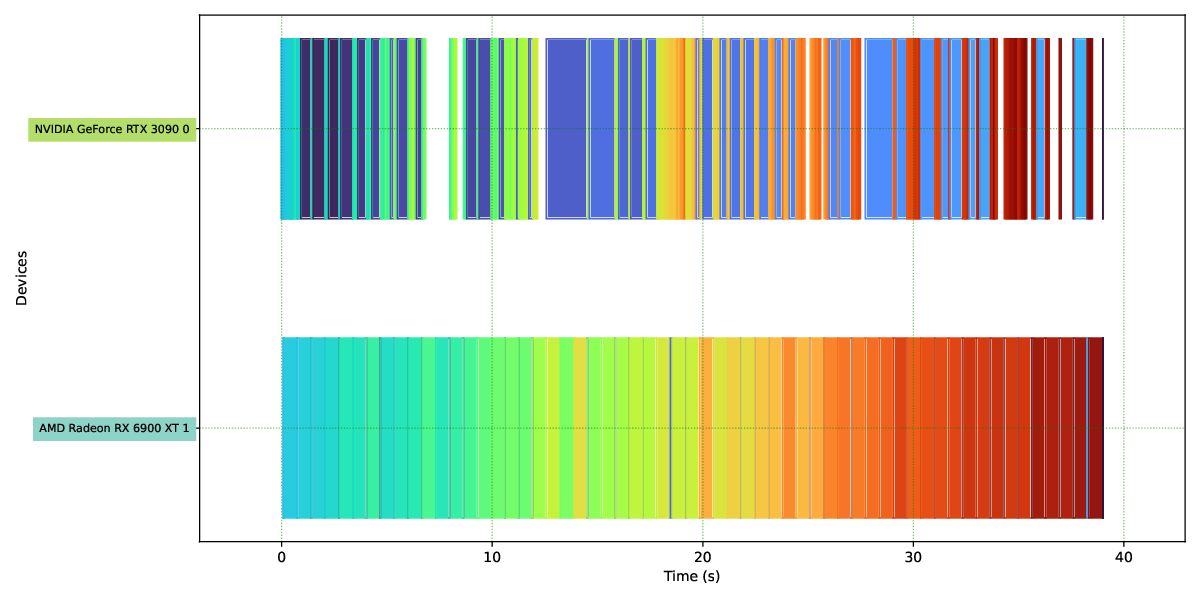

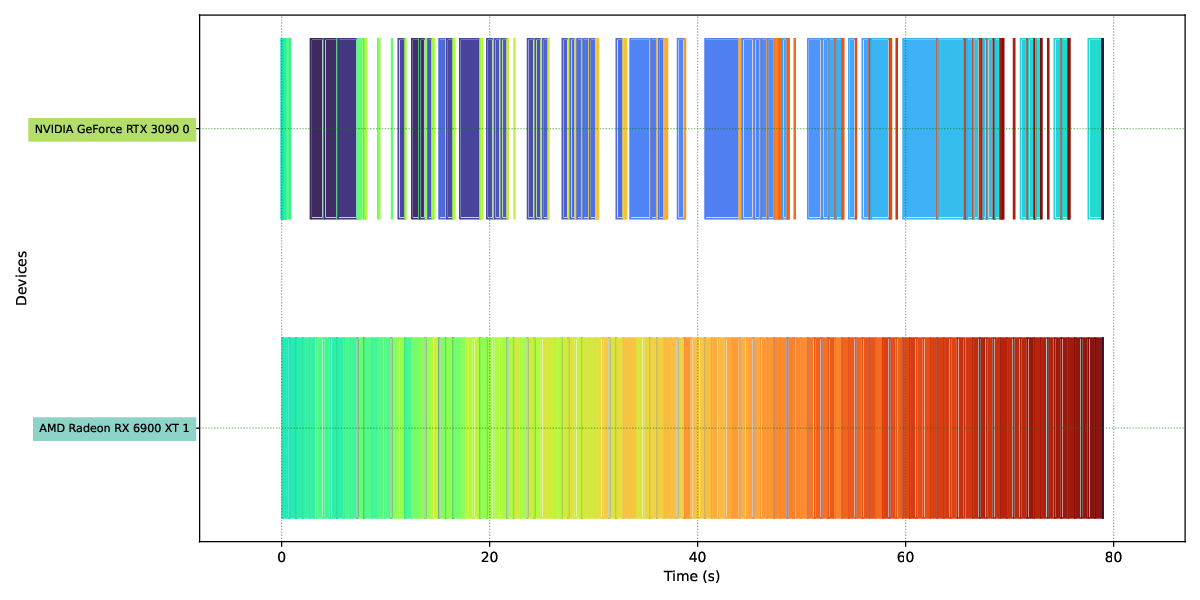

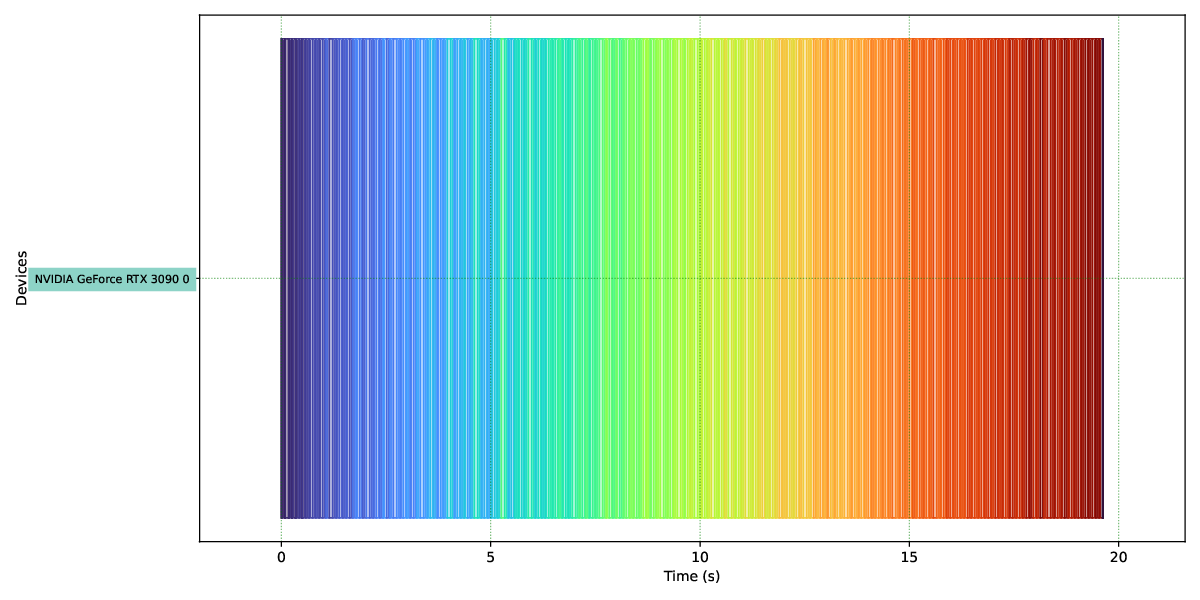

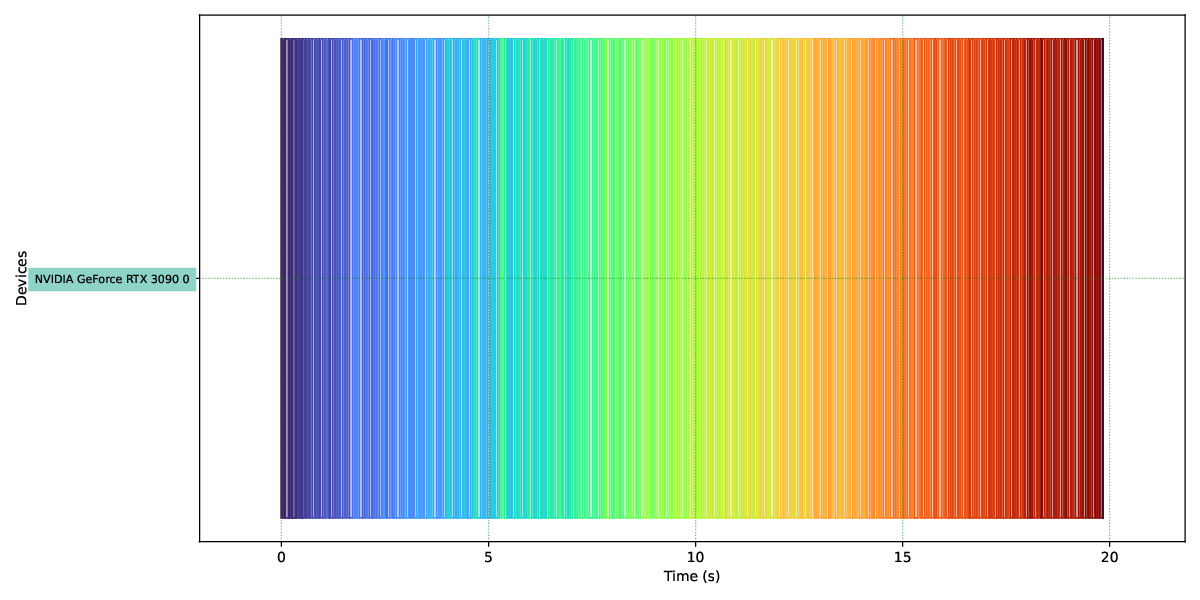

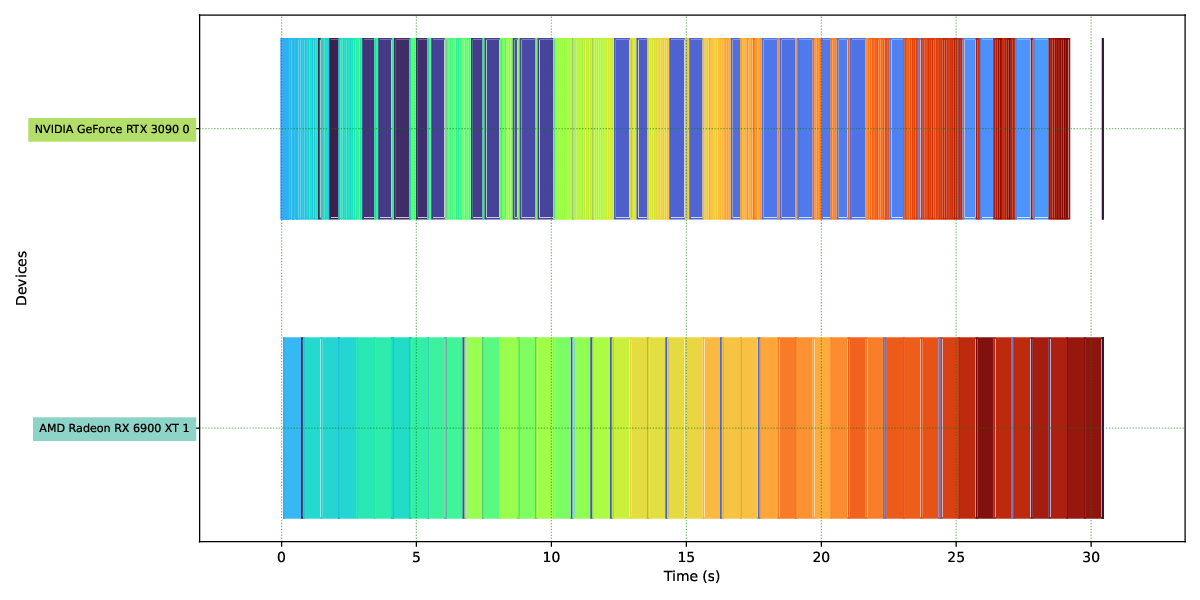

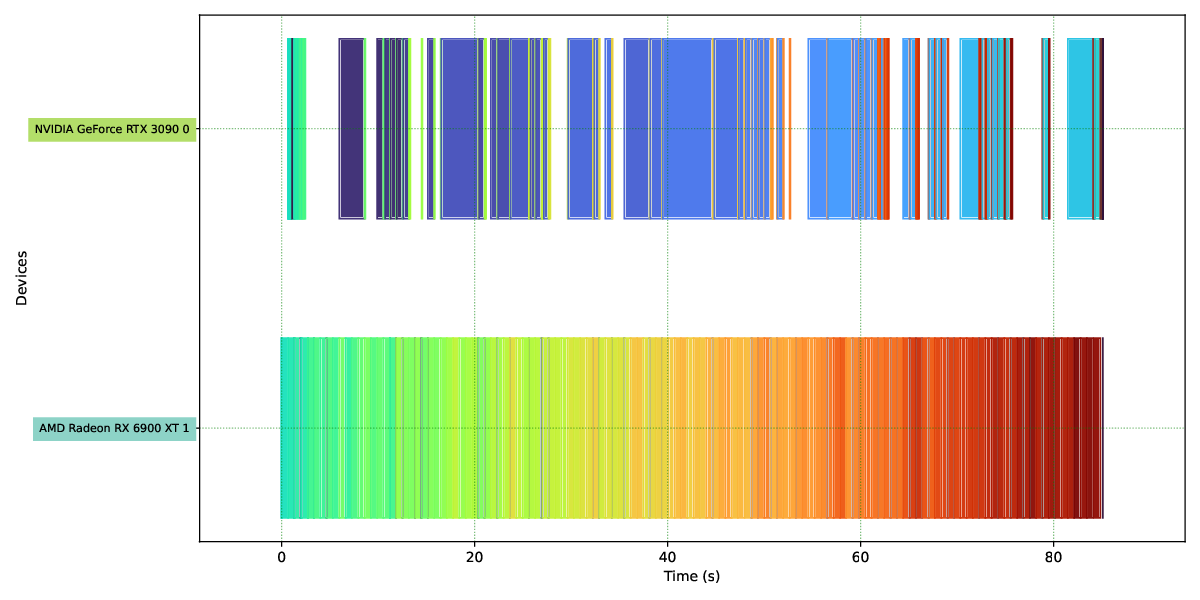

In [71]:
from wand.image import Image as WImage
import glob
timeline_images = glob.glob("zenith-*-timeline.pdf")
images = []
for i in timeline_images:
    print("filename is {}".format(i))
    images.append(WImage(filename=i, resolution=100))
display(*images)

Leconte
----------

filename is leconte-profile-timeline.pdf
filename is leconte-ftf-timeline.pdf
filename is leconte-sdq-timeline.pdf
filename is leconte-depend-timeline.pdf
filename is leconte-roundrobin-timeline.pdf
filename is leconte-random-timeline.pdf


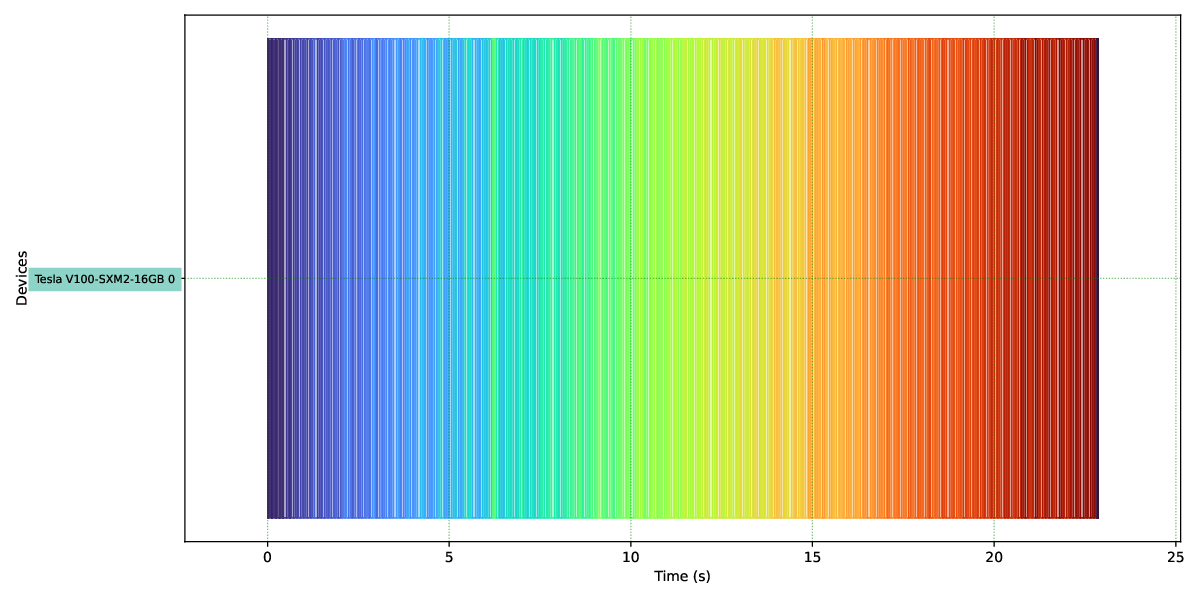

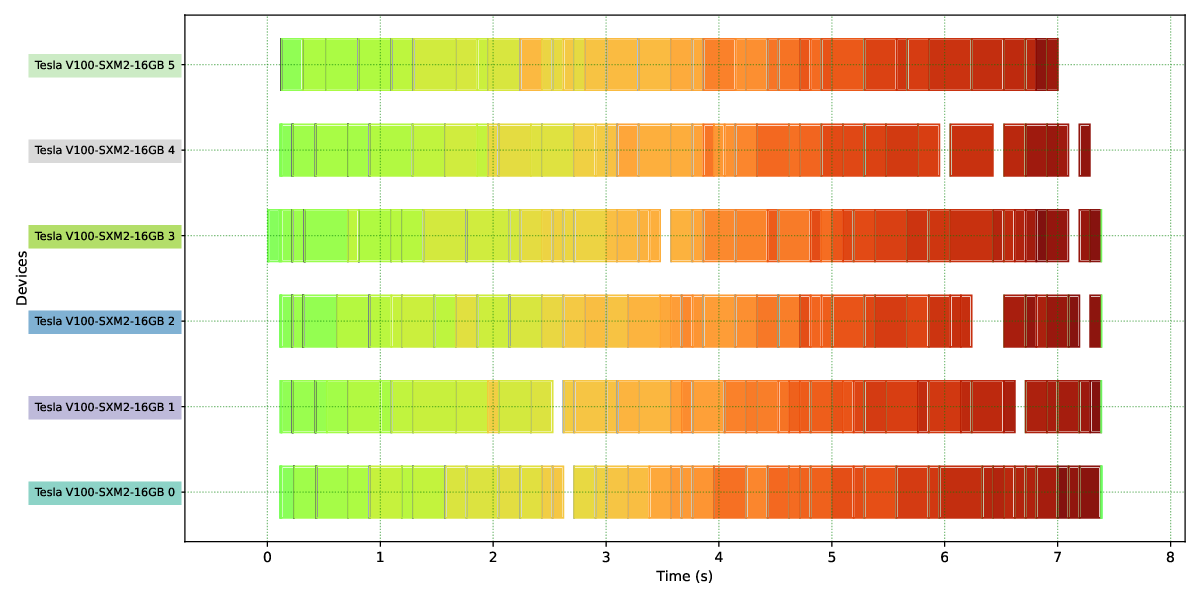

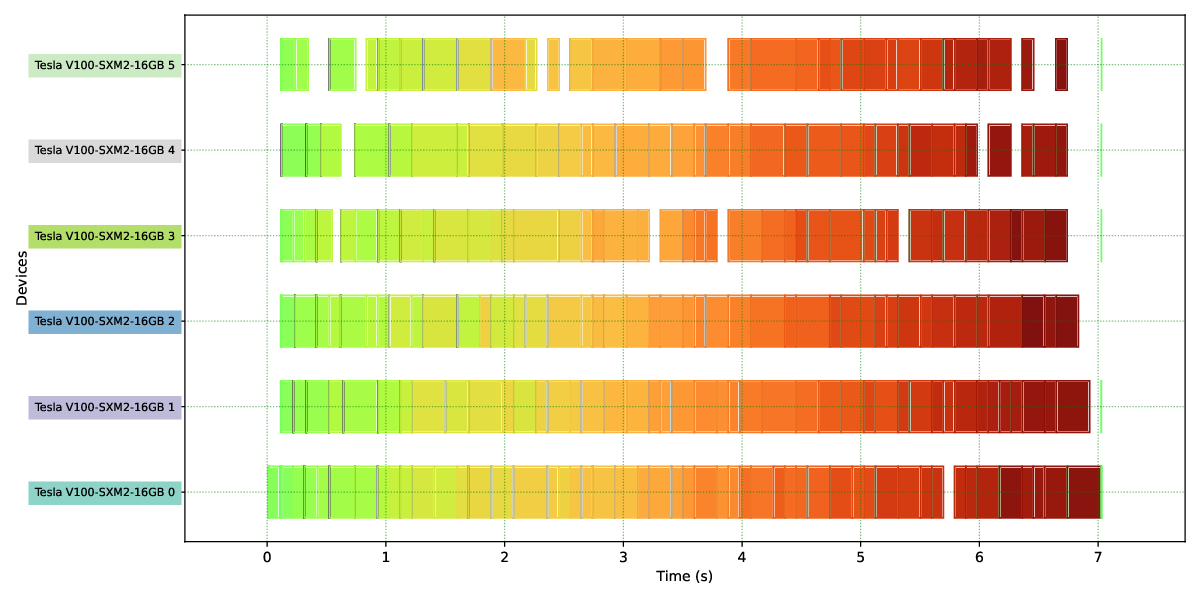

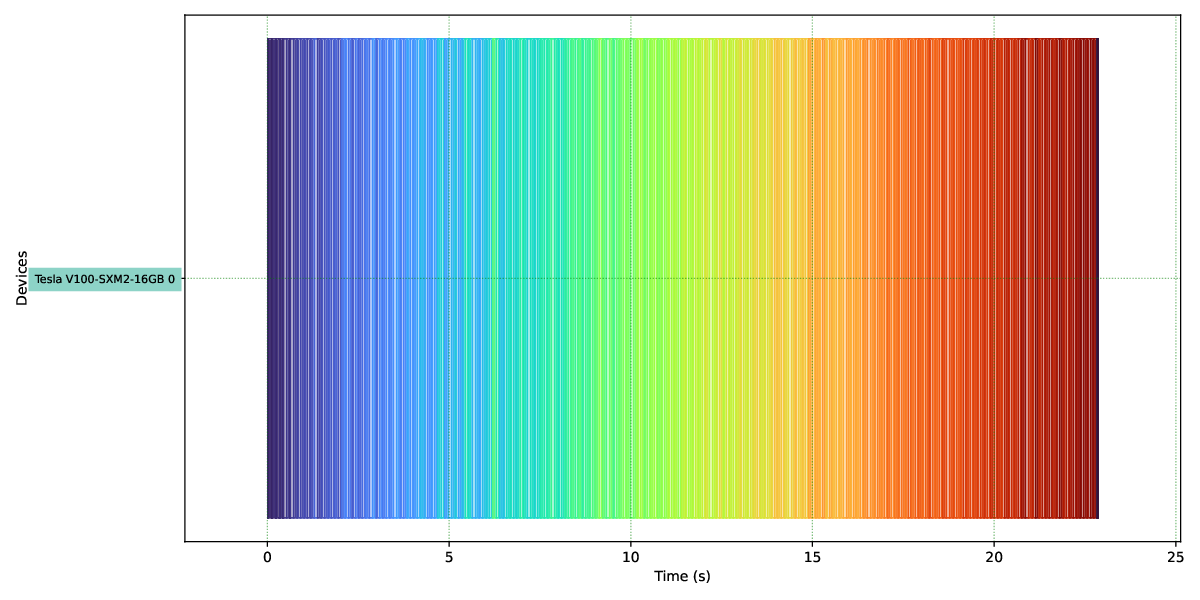

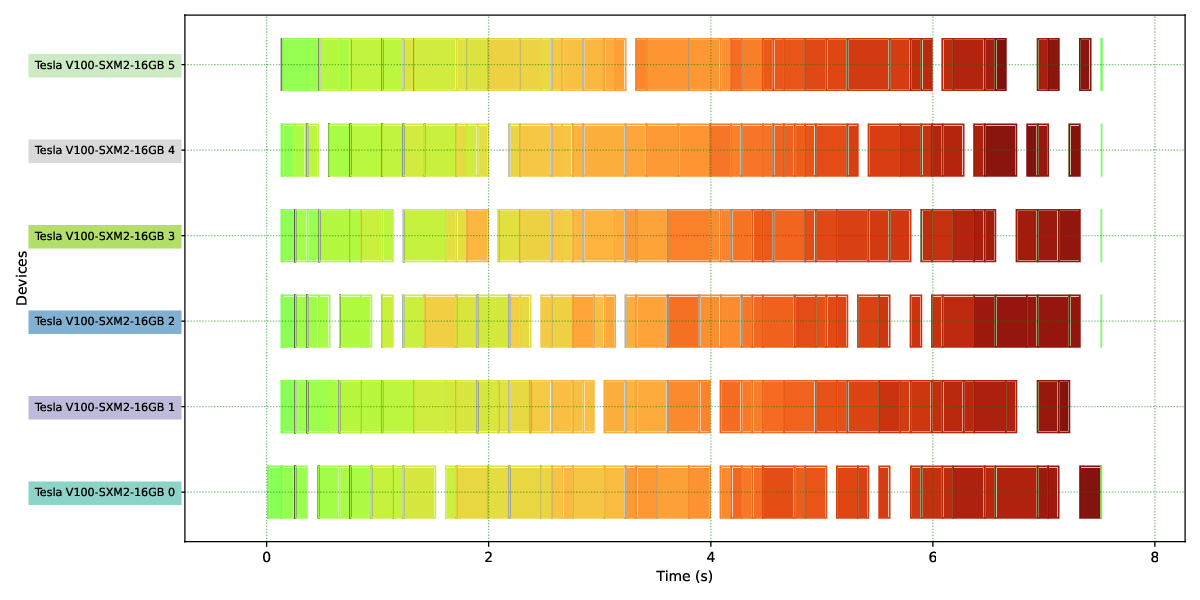

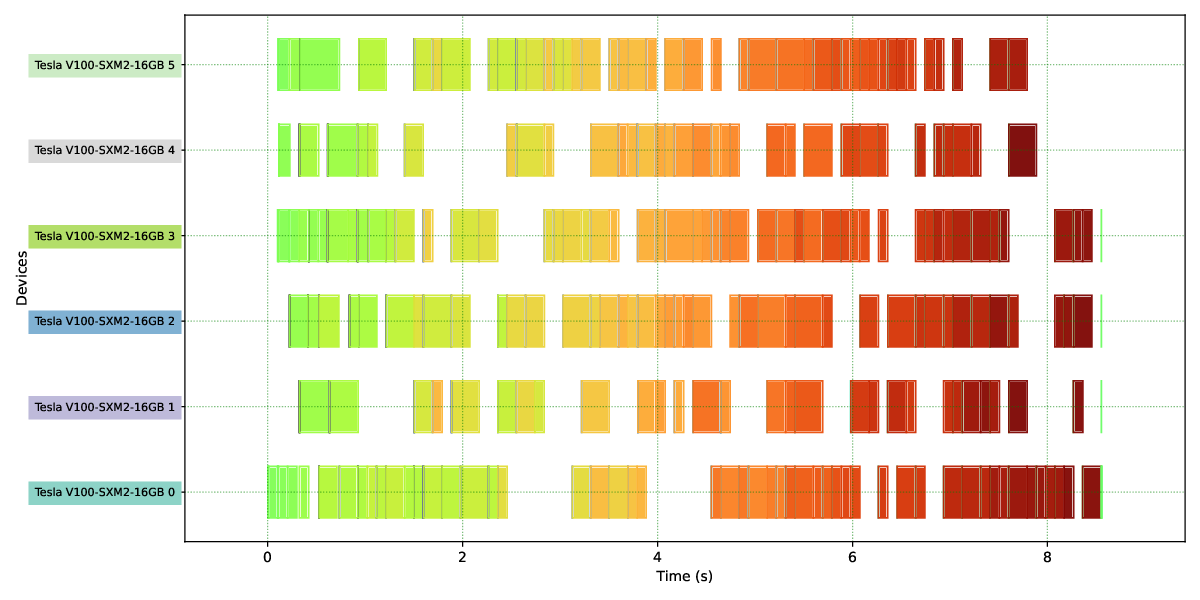

In [72]:
from wand.image import Image as WImage
import glob
timeline_images = glob.glob("leconte-*-timeline.pdf")
images = []
for i in timeline_images:
    print("filename is {}".format(i))
    images.append(WImage(filename=i, resolution=100))
display(*images)

We see that the "depend" policy assigns all tasks to the device which was initially assigned the data and so effectively serializes the job to a single accelerator.

Questions:
-------------
- Why is this the fastest?
- Can we give enough work to justify using a second accelerator?
- Why isn't the CPU (OpenMP) backend used at all?
    + it isn't compiling / resolving the iris_openmp_kernel/iris_openmp_kernel_with_obj for OpenMP kernel:ijk


Future Work:
---------------
* Pin all work to device 0 and compare to the best scheduling policy (minimum absolute execution time)?
* Or many scheduling policies?
* Normalize this according to the number of devices available? Would give a consistent score 0-100
    + automate speedup factors
    + generate bar plot (of all system/policy pairs)
    + script workflow for multiple device targets (rather than having to edit the build script)
    + report how Zenith is the only systems to experience a slow-down when allocating the work amongst multiple devices (because two different device vendors)
    + add local-workgroup-size to the dagger runner to allow larger workgroups to be passed into HIP

           scheduler       secs    system  num_gpus
oswald00      depend  211.75700  oswald00       1.0
radeon        depend  177.04100    radeon       1.0
zenith        depend   19.42040    zenith       2.0
explorer      depend  170.26600  explorer       2.0
equinox       depend   65.05600   equinox       4.0
leconte       depend   22.84700   leconte       6.0
oswald00         ftf  211.74500  oswald00       1.0
radeon           ftf  177.08700    radeon       1.0
zenith           ftf   28.79470    zenith       2.0
explorer         ftf   85.85040  explorer       2.0
equinox          ftf   21.63650   equinox       4.0
leconte          ftf    7.19271   leconte       6.0
oswald00     profile  211.76600  oswald00       1.0
radeon       profile  177.04700    radeon       1.0
zenith       profile   19.52730    zenith       2.0
explorer     profile  170.32700  explorer       2.0
equinox      profile   64.97330   equinox       4.0
leconte      profile   22.81420   leconte       6.0
oswald00    

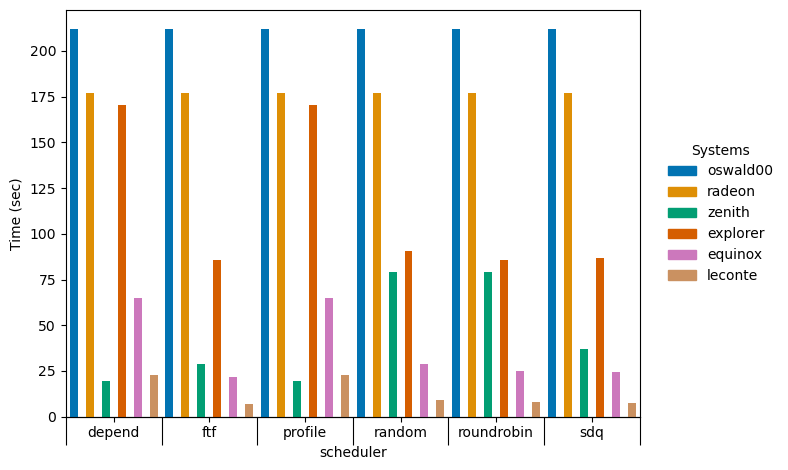

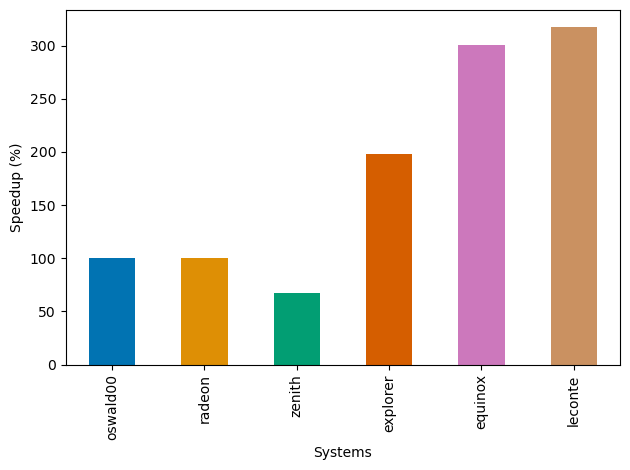

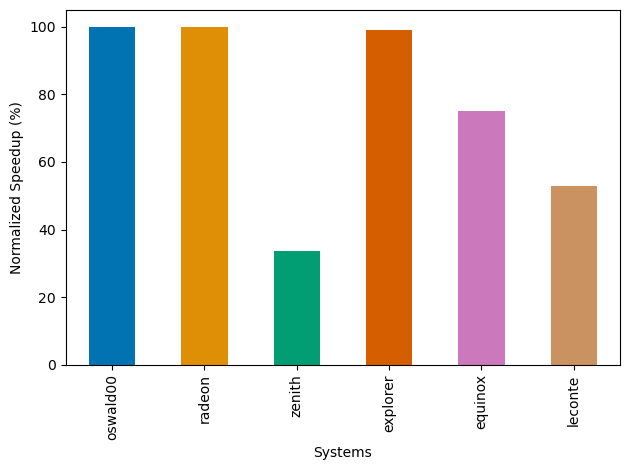

In [320]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as mticker

systems = ['oswald00','radeon','zenith','explorer','equinox','leconte']
num_gpus= [1 ,1, 2, 2, 4, 6]
gpu_sys_map = dict(zip(systems,num_gpus))

#generate the colour palette for each system
palette = sns.color_palette("colorblind", len(systems))

# map names to colors
cmap = dict(zip(systems, palette))
patches = [Patch(color=v, label=k) for k, v in cmap.items()]

times = pd.DataFrame({'scheduler':[],'secs':[]})

#load the last timestamp (finish) from all systems with all scheduling-policies
for i,s in enumerate(systems):
    files = glob.glob("{}-*-time.csv".format(s))
    for f in files:
        cont = pd.read_csv(f)
        row = pd.DataFrame({'scheduler':f.split('-')[1],'secs':max(cont['end']),'system':s, 'num_gpus':gpu_sys_map[s]},index=[s])
        times = pd.concat([times, row])
times.sort_values(['scheduler','num_gpus'],inplace=True)

print(times)

colours = [cmap[s] for s in times.index]

ax = times.plot.bar(x='scheduler',y='secs',color=colours)
ax.set_xticks(np.arange(2.5, len(x), 6), [ax.get_xticklabels()[i].get_text() for i in np.arange(2, len(x), 6)])#reuse old labels but stagger them by half a point
plt.xticks(rotation=0)
plt.tight_layout()
room_sep_ax = ax.secondary_xaxis(location=0)
room_sep_ax.set_xticks(np.arange(-.5,36.5,6),''*6)
room_sep_ax.tick_params('x', length=20)
ax.set_ylabel(r"Time (sec)")
plt.legend(title='Systems', labels=systems, handles=patches, bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0, frameon=False)
plt.savefig('absolute_comparison.pdf',bbox_inches = 'tight')
plt.show()

#relative performance:
depend_df = times[times['scheduler'] == 'depend']
ftf_df = times[times['scheduler'] == 'ftf']
relative_perf=pd.DataFrame({'perf':(depend_df['secs']/ftf_df['secs'] )*100}) 
ax = relative_perf.plot.bar(y='perf',color=colours,legend=None)
#ax.set_ylabel(r"Speedup $\left( \frac{depend}{ftf} \right) \times 100$")
ax.set_ylabel(r"Speedup (%)")
ax.set_xlabel("Systems")
plt.tight_layout()
plt.savefig('relative_comparison.pdf',bbox_inches = 'tight')
plt.show()

#normalized relative performance:
depend_df = times[times['scheduler'] == 'depend']
ftf_df = times[times['scheduler'] == 'ftf']
normalized_perf=pd.DataFrame({'performance':((depend_df['secs']/ftf_df['secs'] )*100 / ftf_df['num_gpus'])})
ax = normalized_perf.plot.bar(y='performance',color=colours,legend=None)
#ax.set_ylabel(r"Speedup $ \left( \frac{\mathit{depend}}{ftf} \right) \times 100 \div $ # GPUs")
ax.set_ylabel(r"Normalized Speedup (%)")
ax.set_xlabel("Systems")
plt.tight_layout()
plt.savefig('normalized_comparison.pdf',bbox_inches = 'tight')
plt.show()
